In [1]:
# Basic imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

loan_data = pd.read_csv('raw_data/loans_v2.csv')

date_cols = [c for c in loan_data.columns if str(c)[-2:]=='Dt']
for col in date_cols:
    loan_data[col] = pd.to_datetime(loan_data[col])

In [12]:
# Filter to loans that have information we would get from a package and format columns for preprocessing
loan_data = loan_data[loan_data['Code'].notna()]
loan_data = loan_data[loan_data['Code']>0]
loan_data['Code'] = loan_data['Code'].astype(int)
loan_data = loan_data[loan_data['Margin'].notna()]
# Filter to all paid off loans
df = loan_data[loan_data['PP_qty'].notna()]
df = df[df['LoanAmt'].notna()]
df = df[df['MatBucket'].notna()]
df.loc[df['MarginBucket'].isna(), 'MarginBucket'] = '0'
df = df[['LoanAmt','MaturityMthsQty','MatBucket','Code','Margin','MarginBucket','state_abbreviation','PP_qty']]

In [45]:

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor
# ML preprocessing imports
import sklearn.preprocessing as skp
# Create label encoder for buckets 
le = skp.LabelEncoder()
# Create dictionary for float scalers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df['Code'] = le.fit_transform(df['Code'])
df['MarginBucket'] = le.fit_transform(df['MarginBucket'])
df['MatBucket'] = le.fit_transform(df['MatBucket'])
df['state_abbreviation'] = le.fit_transform(df['state_abbreviation'])
X = df.drop(columns='PP_qty')
y = df['PP_qty']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1,
                                                    train_size=0.7)
amount_cols = ['LoanAmt', 'MaturityMthsQty']

scaler_dict = {c: None for c in amount_cols}

for key in scaler_dict.keys():
    scaler_dict[key] = skp.MinMaxScaler()
    X_train[key] = scaler_dict[key].fit_transform(X_train[key].values.reshape(-1,1))
    X_test[key] = scaler_dict[key].transform(X_test[key].values.reshape(-1,1))

# Calculated the balanced accuracy score
rf = RandomForestRegressor(n_estimators=1000, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test,y_test)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y_test,y_pred)
print('R-squared:', r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)


R-squared: 0.09425878803825616
RMSE: 32.748471322009365


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor

# Calculated the balanced accuracy score
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)




In [18]:
y_pred = rf.predict(X_test)

In [24]:
pred_vs_actual = pd.DataFrame(dict(actual=y_test,predictions=y_pred)).reset_index().drop(columns='index')

<AxesSubplot: title={'center': 'Features Importances: Top 10'}, ylabel='1'>

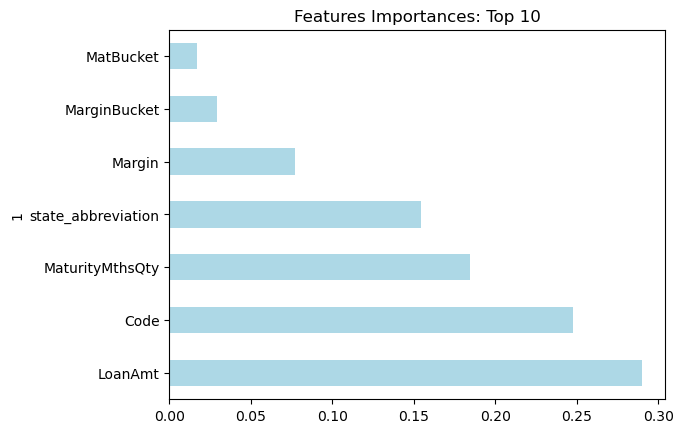

In [42]:

importances_df = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
importances_sorted.head(10).plot(kind='barh', color='lightblue', title= 'Features Importances: Top 10', legend=False)

In [ ]:

importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_df.set_index(importances_df[1], inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
importances_sorted.head(10).plot(kind='barh', color='lightblue', title= 'Features Importances: Top 10', legend=False)

In [43]:
import graphviz